In [1]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
import json
from pygsp import graphs, filters, plotting
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
plotting.BACKEND = 'matplotlib'
%matplotlib inline

In [2]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

In [3]:
len(players_ref_list)

12075

In [4]:
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers

### Data exploration
We want to cast the fee of transfer from string to int. All currencies are expressed in euros <br/>
Mill. is used for millions <br/>
Th. is used for thousands <br/>
\- or ? is used to mark missing entry <br/>
Free Transfer is used to mark 0 value <br/>
Loan fee:amount is used to mark the value under a loan <br/>

In [5]:
missing_fees = 0
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    # missing_fees is to count the number of 
    global missing_fees
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        missing_fees += 1
        processed_fee = 0
    
    return processed_fee

In [6]:
test = parsePlayer(players_ref_list[0])
test

({'birthdate': 'May 11, 1992 ',
  'current_club': 'Chelsea FC',
  'href': '/thibaut-courtois/profil/spieler/108390',
  'name': 'Thibaut Courtois',
  'nationality': 'Belgium',
  'number': '#13',
  'player_id': '108390',
  'position': 'Goalkeeper'},
 [{'date': 'Jun 30, 2014',
   'fee': '25,00 Mill. €',
   'from': '13',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 27, 2011',
   'fee': 'Loan fee:1,20 Mill. €',
   'from': '631',
   'player': '108390',
   'to': '13'},
  {'date': 'Jul 26, 2011',
   'fee': '8,95 Mill. €',
   'from': '1184',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 1, 2009',
   'fee': '-',
   'from': '3494',
   'player': '108390',
   'to': '1184'},
  {'date': 'Jul 1, 2008',
   'fee': '-',
   'from': '49393',
   'player': '108390',
   'to': '3494'},
  {'date': 'Jul 1, 2007',
   'fee': '-',
   'from': '34282',
   'player': '108390',
   'to': '49393'}])

## Build graph of players

In [ ]:
# compute the average number of times a player changes clubs
number_of_transfers = 0

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    number_of_transfers += len(player[1])
    
print ("The average player from our dataset has transferred {} many times".format(number_of_transfers/len(players_ref_list)))

In [7]:
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs_ref_list = json.load(in_file)

In [8]:
# Multiply the number of clubs with the number of players of the first one
# This is close to the number of players we have parsed

print (len(clubs_ref_list)*len(clubs_ref_list[0]['players']))

10868


In [9]:
# We need to reduce the number of nodes to actual number of clubs. However, this will make us lose the indexing
width = len(clubs_ref_list)
print (len(clubs_ref_list))

418


In [10]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [11]:
club_ids = []
for club in clubs_ref_list:
    club_ids.append(int(club['href'].split("/")[-3]))
    
club_ids = sorted(club_ids)

There are some players that are being transfered from one club to another, with the clubs being small to the point that we shouldn't need them. If we only keep the clubs without any zero row, we would keep 7220 club. But from our previous club data, we only considered 418 clubs.
We might consider putting a constraint when adding the node. However, we would lose the index of the club. We could keep the 56089 clubs (which only depended on the id of the club) but it would lead to more computations and is not beneficial.

In [12]:
# Fill the Adjacency matrix with one when transfer from one club to another
# for player_ref in players_ref_list:
#     player = parsePlayer(player_ref)
#     try:
#         for transfer in player[1]:
#             from_club = int(transfer["from"])
#             to_club = int(transfer["to"])
#             if(from_club in club_ids and to_club in club_ids):
#                 W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
#                 W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
#     except:
#         pass

In [14]:
W.shape[0]

418

In [15]:
number_of_inner_transfers = 0
for i in range(W.shape[0]):
    if(W[i][i] == 1):
        number_of_inner_transfers += 1
        
print ("There have been {} innertransfers".format(number_of_inner_transfers))

There have been 0 innertransfers


In [16]:
# Set all the transfers within the same club to zero -> no self-loops
np.fill_diagonal(W, 0)

In [46]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
# np.save('adj_matrix.npy', W)

## Load directly filled matrix

In [13]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix.npy')

In [17]:
# Here temp_W contains the clubs that are not necessarily from the 418 clubs we selected
print (W.shape)

(418, 418)


In [89]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


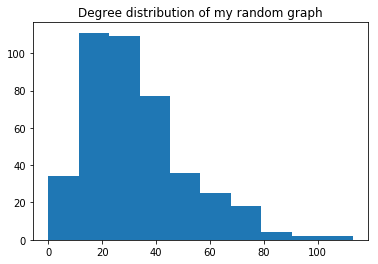

In [90]:
plt.hist(G.d)
plt.title('Degree distribution of my random graph');

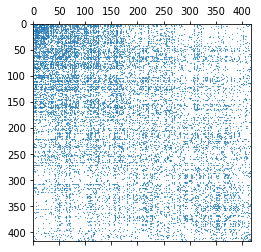

In [106]:
plt.spy(G.W, markersize=0.20)


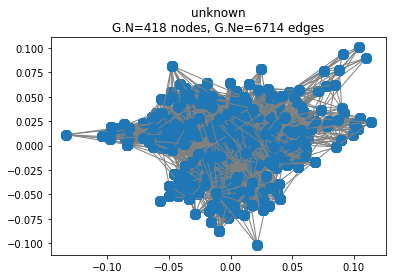

In [104]:
G.set_coordinates('spring')
plotting.plot_graph(G)

## Compute eigenvalues and eigenvectors

In [243]:
G=nx.from_numpy_matrix(W)
laplacian = nx.normalized_laplacian_matrix(G)

In [259]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian, k = 10, which = 'SM')
eigenvalues

array([  1.65951120e-17+0.j,  -1.59767181e-16+0.j,   2.26177619e-01+0.j,
         1.53788795e-16+0.j,   5.55111512e-17+0.j,  -2.64104828e-16+0.j,
         1.72501275e-17+0.j,   1.37321520e-16+0.j,   6.38401720e-17+0.j,
         5.55111512e-17+0.j])

In [261]:
print (eigenvectors.shape)

(418, 10)


/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


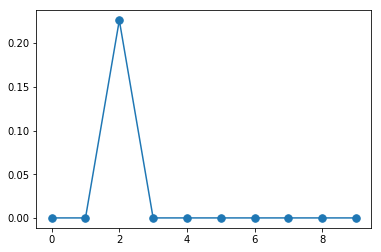

In [262]:
plt.plot(eigenvalues, '.-', markersize=15);

# Data visualization/exploration

In [198]:
nationalities = []
birthdays_month = []

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        nationalities.append(player[0]['nationality'])
        bday = player[0]["birthdate"].replace(",","").strip()
        datetime_object = datetime.strptime(bday, '%b %d %Y')
        birthdays_month.append(datetime_object.month)
    except:
        nationalities.append("N/A")
        birthdays_month.append("N/A")

In [222]:
# Sort nationalities by most common
nationalities_counter = Counter(nationalities).most_common()
index = []
iterator = 1
nationalities = []
nationalities_count = []
for nationality in nationalities_counter:
    index.append(iterator)
    iterator += 1
    nationalities.append(nationality[0])
    nationalities_count.append(nationality[1])

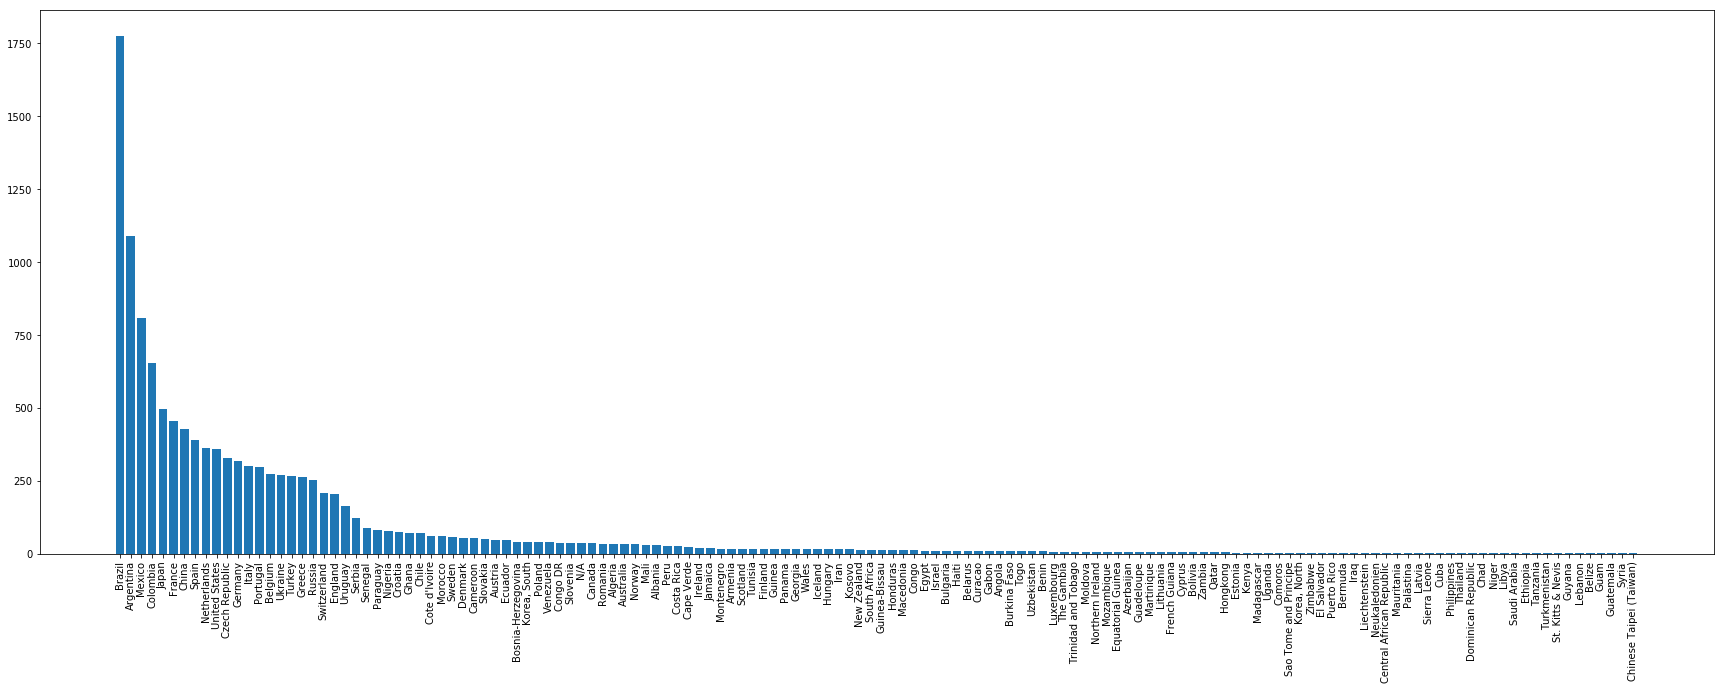

In [240]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, nationalities_count, align='center')
plt.xticks(index, nationalities,rotation=90)
plt.show()
